In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from networkx.algorithms import approximation as approx
import sklearn.metrics as mt

Imported the data from the dataset

In [2]:
# Load the dataset directly from a CSV file
file_path = 'soc-sign-bitcoinalpha.csv'
data = pd.read_csv(file_path, header=None, names=['source', 'target', 'rating', 'time'])

# Display the first few rows of the data to understand its structure
print("Initial data preview:")
print(data.head())

data['time'] = pd.to_datetime(data['time'], unit='s')  # Assuming 'time' is a UNIX timestamp
print("\nData types after conversion:")
print(data.info)

Initial data preview:
   source  target  rating        time
0    7188       1      10  1407470400
1     430       1      10  1376539200
2    3134       1      10  1369713600
3    3026       1      10  1350014400
4    3010       1      10  1347854400

Data types after conversion:
<bound method DataFrame.info of        source  target  rating                time
0        7188       1      10 2014-08-08 04:00:00
1         430       1      10 2013-08-15 04:00:00
2        3134       1      10 2013-05-28 04:00:00
3        3026       1      10 2012-10-12 04:00:00
4        3010       1      10 2012-09-17 04:00:00
...       ...     ...     ...                 ...
24181    7604    7601      10 2013-03-26 04:00:00
24182    7601    7604      10 2013-03-26 04:00:00
24183    7604    7602      10 2013-03-26 04:00:00
24184    7602    7604      10 2013-03-26 04:00:00
24185    7604    7603     -10 2013-03-26 04:00:00

[24186 rows x 4 columns]>


Starting from the original dataset I create a new balanced dataset and I save it to csv

In [3]:
negative_data = data.query("rating < 1")
positive_data = data.query("rating > 0")

balanced_data = pd.concat([negative_data, positive_data.sample(n=negative_data.shape[0])])
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)

#balanced_data.to_csv('balanced_dataset.csv', index=False, header=False)

I read the balanced dataset for using it later

In [6]:
data = pd.read_csv('balanced_dataset.csv', header=None, names=['source', 'target', 'rating', 'time'])

# Randomly sample 70% of the data for training
balanced_train_data = data.sample(frac=0.8, random_state=42)

# The remaining 30% will be used for testing
balanced_test_data = data.drop(balanced_train_data.index)

# Save train_data and test_data to separate files
#balanced_train_data.to_csv('balanced_train_data.csv', index=False, header=False)
#balanced_test_data.to_csv('balanced_test_data.csv', index=False, header=False)

The graph is created starting from the balanced training set

In [2]:
train_data = pd.read_csv('balanced_train_data.csv', header=None, names=['source', 'target', 'rating', 'time'])
# Creating a network graph from the DataFrame
G = nx.from_pandas_edgelist(train_data, 'source', 'target', edge_attr='rating', create_using=nx.DiGraph())

# Basic network statistics
print("\nNetwork statistics:")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())




Network statistics:
Number of nodes: 1502
Number of edges: 2458


I use pageRank for ranking the most important nodes in the graph. I also calculate the trust score mean for every node.

In [3]:
pr = nx.pagerank(G)
df = pd.DataFrame(sorted(pr.items(), key=lambda item: item[1], reverse=True))
means = []
n_edges = []
for idx in df.index:
    aa = train_data.query("source == @df[0][@idx] or target == @df[0][@idx]")
    means.append(aa['rating'].mean())
    n_edges.append(aa.shape[0])
df['mean'] = means
df['n_edges'] = n_edges

df.rename(columns={0: "node", 1: "page_rank"}).head()





,node,page_rank,mean,n_edges
0,7604,0.012285,-8.327869,61
1,7603,0.009309,-4.974359,39
2,177,0.008601,-4.149254,67
3,7564,0.007965,-7.176471,34
4,798,0.006808,-3.230769,26


In [4]:
a = df.query("mean > 0").rename(columns={0: "node", 1: "page_rank"})
a.head()

,node,page_rank,mean,n_edges
7,1,0.005547,1.750000,44
8,2,0.005213,0.138889,36
11,16,0.004561,0.684211,19
13,22,0.003996,0.423077,26
17,17,0.003396,2.000000,13


The worst node is 7604. The "best" is 1

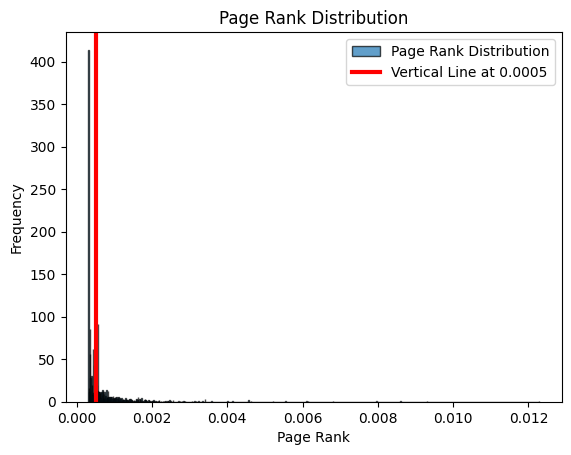

In [20]:
aa = df.rename(columns={0: "node", 1: "page_rank"})
plt.hist(aa['page_rank'], bins=1000, edgecolor='black', alpha=0.7, label='Page Rank Distribution')
plt.axvline(0.0005, color='r', linestyle='solid', linewidth=3, label='Vertical Line at 0.0005')

plt.xlabel('Page Rank')
plt.ylabel('Frequency')
plt.title('Page Rank Distribution')
plt.legend()
plt.show()

The graph has 1502 nodes. I decided to reduce the size of the graph by taking only the nodes with rate >= 0.0005 for computational problems

In [22]:
df = df.rename(columns={1:"rate", 0: "node"})
reducedDf = df.query("rate <= 0.0005")
reducedDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 865 entries, 637 to 1501
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   node     865 non-null    int64  
 1   rate     865 non-null    float64
 2   mean     865 non-null    float64
 3   n_edges  865 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 33.8 KB


Created the new graph with the reduced nodes list

In [23]:
nodes = reducedDf['node']
G_reduced = G.copy()
print(G.number_of_edges())
print(G.number_of_nodes())
G_reduced.remove_nodes_from(nodes)
print(G_reduced.number_of_edges())
print(G_reduced.number_of_nodes())


2458
1502
1249
637


Starting from the graph I created the new training set

In [24]:
edges = G_reduced.edges()
reduced_training_set = pd.DataFrame()
s1 = []
t1 = []
w1 = []
for edge in edges:
    s1.append(edge[0])
    t1.append(edge[1])
    w1.append(G_reduced.get_edge_data(edge[0], edge[1])['rating'])
reduced_training_set['source'] = s1
reduced_training_set['target'] = t1
reduced_training_set['rating'] = w1

reduced_training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   source  1249 non-null   int64
 1   target  1249 non-null   int64
 2   rating  1249 non-null   int64
dtypes: int64(3)
memory usage: 29.4 KB


Starting from the balanced test set I created a new test set. There will be only the edges that have at least one node in the graph

In [25]:
test_data = pd.read_csv("balanced_test_data.csv", header=None, names=['source', 'target', 'rating', 'time'])

filtered_data = test_data[test_data['source'].apply(G_reduced.has_node) | test_data['target'].apply(G_reduced.has_node)]
filtered_data = filtered_data.drop(['time'], axis=1)

reduced_test_set = filtered_data
reduced_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546 entries, 0 to 613
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   source  546 non-null    int64
 1   target  546 non-null    int64
 2   rating  546 non-null    int64
dtypes: int64(3)
memory usage: 17.1 KB


Printed the dataset to csv

In [102]:
reduced_training_set.to_csv("reduced_training_set.csv", header=None)
reduced_test_set.to_csv("reduced_test_set.csv", header=None)

Here I tested that the simrank is different if the node 400 is linked to the node 15 or 272

In [85]:
G_test = G_reduced.copy()
G_test.add_edge(272,400)
print(nx.simrank_similarity(G_test, 400, 7604))
G_test.remove_edge(272,400)
G_test.add_edge(15,400)
G_test.add_edge
print(nx.simrank_similarity(G_test, 400, 7604))

0.018196917711783615
0.02842203864983004


Now we calculated the similarity between every node of the graph with the worst one

In [26]:
unique_nodes_training = G_reduced.nodes
simrank_worst_node = dict()
ind = 0
for node in unique_nodes_training:
    ind = ind + 1
    simrank_worst_node[node] = nx.simrank_similarity(G_reduced, node, 7604)
    print(ind,"/",len(unique_nodes_training))

1 / 637
2 / 637
3 / 637
4 / 637
5 / 637
6 / 637
7 / 637
8 / 637
9 / 637
10 / 637
11 / 637
12 / 637
13 / 637
14 / 637
15 / 637
16 / 637
17 / 637
18 / 637
19 / 637
20 / 637
21 / 637
22 / 637
23 / 637
24 / 637
25 / 637
26 / 637
27 / 637
28 / 637
29 / 637
30 / 637
31 / 637
32 / 637
33 / 637
34 / 637
35 / 637
36 / 637
37 / 637
38 / 637
39 / 637
40 / 637
41 / 637
42 / 637
43 / 637
44 / 637
45 / 637
46 / 637
47 / 637
48 / 637
49 / 637
50 / 637
51 / 637
52 / 637
53 / 637
54 / 637
55 / 637
56 / 637
57 / 637
58 / 637
59 / 637
60 / 637
61 / 637
62 / 637
63 / 637
64 / 637
65 / 637
66 / 637
67 / 637
68 / 637
69 / 637
70 / 637
71 / 637
72 / 637
73 / 637
74 / 637
75 / 637
76 / 637
77 / 637
78 / 637
79 / 637
80 / 637
81 / 637
82 / 637
83 / 637
84 / 637
85 / 637
86 / 637
87 / 637
88 / 637
89 / 637
90 / 637
91 / 637
92 / 637
93 / 637
94 / 637
95 / 637
96 / 637
97 / 637
98 / 637
99 / 637
100 / 637
101 / 637
102 / 637
103 / 637
104 / 637
105 / 637
106 / 637
107 / 637
108 / 637
109 / 637
110 / 637
111 / 63

I will do the same for the best node

In [27]:
simrank_best_node = dict()
ind = 0
for node in unique_nodes_training:
    ind = ind + 1
    simrank_best_node[node] = nx.simrank_similarity(G_reduced, node, 1)
    print(ind,"/",len(unique_nodes_training))

1 / 637
2 / 637
3 / 637
4 / 637
5 / 637
6 / 637
7 / 637
8 / 637
9 / 637
10 / 637
11 / 637
12 / 637
13 / 637
14 / 637
15 / 637
16 / 637
17 / 637
18 / 637
19 / 637
20 / 637
21 / 637
22 / 637
23 / 637
24 / 637
25 / 637
26 / 637
27 / 637
28 / 637
29 / 637
30 / 637
31 / 637
32 / 637
33 / 637
34 / 637
35 / 637
36 / 637
37 / 637
38 / 637
39 / 637
40 / 637
41 / 637
42 / 637
43 / 637
44 / 637
45 / 637
46 / 637
47 / 637
48 / 637
49 / 637
50 / 637
51 / 637
52 / 637
53 / 637
54 / 637
55 / 637
56 / 637
57 / 637
58 / 637
59 / 637
60 / 637
61 / 637
62 / 637
63 / 637
64 / 637
65 / 637
66 / 637
67 / 637
68 / 637
69 / 637
70 / 637
71 / 637
72 / 637
73 / 637
74 / 637
75 / 637
76 / 637
77 / 637
78 / 637
79 / 637
80 / 637
81 / 637
82 / 637
83 / 637
84 / 637
85 / 637
86 / 637
87 / 637
88 / 637
89 / 637
90 / 637
91 / 637
92 / 637
93 / 637
94 / 637
95 / 637
96 / 637
97 / 637
98 / 637
99 / 637
100 / 637
101 / 637
102 / 637
103 / 637
104 / 637
105 / 637
106 / 637
107 / 637
108 / 637
109 / 637
110 / 637
111 / 63

In [28]:
def preProcessData(G, data, simrank_worst_node, simrank_best_node, mode):
    featureSet = pd.DataFrame()
    eig_cent_source = []
    eig_cent_target = []
    degree_source = []
    degree_target = []
    rank_source = []
    rank_target = []
    sim_worst_source = []
    sim_worst_target = []
    sim_best_source = []
    sim_best_target = []

    eig_centrality = nx.eigenvector_centrality(G, max_iter=600, tol=1.0e-3)

    for ind in data.index:
        source = data['source'][ind]
        target = data['target'][ind]

        e1 = eig_centrality.get(source)
        e2 = eig_centrality.get(target)
        if e1: 
            eig_cent_source.append(e1)
        else: 
            eig_cent_source.append(0)
        
        if e2: 
            eig_cent_target.append(e2)
        else: 
            eig_cent_target.append(0)
            
        if mode >= 1:
            d1 = G.degree([source])
            d2 = G.degree([data['target'][ind]])
            if len(d1) != 0: 
                degree_source.append(G.degree[data['source'][ind]])
            else: 
                degree_source.append(0)
            
            if len(d2) != 0: 
                degree_target.append(G.degree[data['target'][ind]])
            else: 
                degree_target.append(0)
    
        if mode >= 2:
            r1 = pr.get(data['source'][ind])
            r2 = pr.get(data['target'][ind])
            if r1: 
                rank_source.append(r1)
            else: 
                rank_source.append(0)
            
            if r2: 
                rank_target.append(r2)
            else: 
                rank_target.append(0)
        
        if mode >= 3:
            sim_worst_source.append(simrank_worst_node.get(source))
            sim_worst_target.append(simrank_worst_node.get(target))
            sim_best_source.append(simrank_best_node.get(source))
            sim_best_target.append(simrank_best_node.get(target))
        
        

    featureSet['source'] = data['source']
    featureSet['target'] = data['target']
    featureSet['eig_cent_source'] = eig_cent_source
    featureSet['eig_cent_target'] = eig_cent_target
    if mode >= 1:
        featureSet['degree_source'] = degree_source
        featureSet['degree_target'] = degree_target
    if mode >= 2:
        featureSet['rank_source'] = rank_source
        featureSet['rank_target'] = rank_target
    if mode >= 3:
        featureSet['sim_worst_source'] = sim_worst_source
        featureSet['sim_worst_target'] = sim_worst_target
        featureSet['sim_best_source'] = sim_best_source
        featureSet['sim_best_target'] = sim_best_target
    featureSet['rating'] = data['rating']
    
    return featureSet
        

In [29]:
def preProcessInputData(G, data, simrank_worst_node, simrank_best_node, mode):
    featureSet = pd.DataFrame()
    eig_cent_source = []
    eig_cent_target = []
    degree_source = []
    degree_target = []
    rank_source = []
    rank_target = []
    sim_worst_source = []
    sim_worst_target = []
    sim_best_source = []
    sim_best_target = []

    for ind in data.index:
        source = data['source'][ind]
        target = data['target'][ind]
        G.add_edge(source, target)

        eig_centrality = nx.eigenvector_centrality(G, max_iter=600)
        pr = nx.pagerank(G, max_iter=600) 

        e1 = eig_centrality.get(source)
        e2 = eig_centrality.get(target)
        if e1: 
            eig_cent_source.append(e1)
        else: 
            eig_cent_source.append(0)
        
        if e2: 
            eig_cent_target.append(e2)
        else: 
            eig_cent_target.append(0)
            
        if mode >= 1:
            d1 = G.degree([source])
            d2 = G.degree([data['target'][ind]])
            if len(d1) != 0: 
                degree_source.append(G.degree[data['source'][ind]])
            else: 
                degree_source.append(0)
            
            if len(d2) != 0: 
                degree_target.append(G.degree[data['target'][ind]])
            else: 
                degree_target.append(0)
    
        if mode >= 2:
            r1 = pr.get(data['source'][ind])
            r2 = pr.get(data['target'][ind])
            if r1: 
                rank_source.append(r1)
            else: 
                rank_source.append(0)
            
            if r2: 
                rank_target.append(r2)
            else: 
                rank_target.append(0)
        
        if mode >= 3:
            if simrank_worst_node.get(source) != None:
                sim_worst_source.append(simrank_worst_node.get(source))
                sim_best_source.append(simrank_best_node.get(source))
            else:
                simrank_worst = nx.simrank_similarity(G, source, 7604)
                simrank_best = nx.simrank_similarity(G, source, 1)
                sim_worst_source.append(simrank_worst)
                sim_best_source.append(simrank_best)
                simrank_worst_node[source] = simrank_worst
                simrank_best_node[source] = simrank_best

            if simrank_worst_node.get(target) != None:
                sim_worst_target.append(simrank_worst_node.get(target))
                sim_best_target.append(simrank_best_node.get(target))
            else:
                simrank_worst = nx.simrank_similarity(G, target, 7604)
                simrank_best = nx.simrank_similarity(G, target, 1)
                sim_worst_target.append(simrank_worst)
                sim_best_target.append(simrank_best)
                simrank_worst_node[target] = simrank_worst
                simrank_best_node[target] = simrank_best
        
        G.remove_edge(source, target)

        

    featureSet['source'] = data['source']
    featureSet['target'] = data['target']
    featureSet['eig_cent_source'] = eig_cent_source
    featureSet['eig_cent_target'] = eig_cent_target
    if mode >= 1:
        featureSet['degree_source'] = degree_source
        featureSet['degree_target'] = degree_target
    if mode >= 2:
        featureSet['rank_source'] = rank_source
        featureSet['rank_target'] = rank_target
    if mode >= 3:
        featureSet['sim_worst_source'] = sim_worst_source
        featureSet['sim_worst_target'] = sim_worst_target
        featureSet['sim_best_source'] = sim_best_source
        featureSet['sim_best_target'] = sim_best_target
    featureSet['rating'] = data['rating']
    
    return featureSet, simrank_worst_node, simrank_best_node


Creation of the datasets for training the model

In [30]:
trainingData = pd.read_csv("reduced_training_set.csv", header=None, names=['source', 'target', 'rating'])
testData = pd.read_csv("reduced_test_set.csv", header=None, names=['source', 'target', 'rating'])

# set1
trainingSet = preProcessData(G_reduced, trainingData, simrank_worst_node, simrank_best_node, 1)
y_train = trainingSet['rating']
X_train = trainingSet.drop('rating', axis=1)

testSet, simrank_worst_node, simrank_best_node = preProcessInputData(G_reduced, testData, simrank_worst_node, simrank_best_node, 1)
testSet.head()
y_test = testSet['rating']
X_test = testSet.drop('rating', axis=1)

#set2
trainingSet1 = preProcessData(G_reduced, trainingData, simrank_worst_node, simrank_best_node, 2)
y_train1 = trainingSet1['rating']
X_train1 = trainingSet1.drop('rating', axis=1)

testSet1, simrank_worst_node, simrank_best_node = preProcessInputData(G_reduced, testData, simrank_worst_node, simrank_best_node, 2)
y_test1 = testSet1['rating']
X_test1 = testSet1.drop('rating', axis=1)

#set 3
trainingSet2 = preProcessData(G_reduced, trainingData, simrank_worst_node, simrank_best_node, 3)
y_train2 = trainingSet2['rating']
X_train2 = trainingSet2.drop('rating', axis=1)

testSet2, simrank_worst_node, simrank_best_node = preProcessInputData(G_reduced, testData, simrank_worst_node, simrank_best_node, 3)
y_test2 = testSet2['rating']
X_test2 = testSet2.drop('rating', axis=1)

In [31]:
X_train2.head()

,source,target,eig_cent_source,eig_cent_target,degree_source,degree_target,rank_source,rank_target,sim_worst_source,sim_worst_target,sim_best_source,sim_best_target
0,7363,7502,0.004566,0.026701,2,4,0.000764,0.001083,0.025743,0.032000,0.024126,0.024956
1,7502,125,0.026701,0.038597,4,11,0.001083,0.001942,0.032000,0.031241,0.024956,0.024328
2,7502,7363,0.026701,0.004566,4,2,0.001083,0.000764,0.032000,0.025743,0.024956,0.024126
3,272,7571,0.012534,0.004777,14,3,0.001110,0.000816,0.033478,0.021571,0.019166,0.017209
4,272,7596,0.012534,0.023733,14,5,0.001110,0.002417,0.033478,0.032538,0.019166,0.022391


Training and testing the models

In [32]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None)

# # model
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

#model 1
rf_model.fit(X_train1, y_train1)
y_pred1 = rf_model.predict(X_test1)

#model 2
rf_model.fit(X_train2, y_train2)
y_pred2 = rf_model.predict(X_test2)



Evaluating the models

In [117]:
treshold = 3

pred = pd.DataFrame()
pred["actual"] = y_test
pred["pred"] = y_pred
acc = []
for i in range(0,treshold):
    accuracy_array = []
    for idx in pred.index:
        a = pred["actual"][idx]
        p = pred["pred"][idx]
        accuracy_array.append(abs(a-p))
    accuracy_arr = np.array(accuracy_array)
    score = np.count_nonzero(accuracy_arr <= i)/accuracy_arr.size
    acc.append(score)
acc.append(mt.mean_squared_error(pred["actual"], pred["pred"]))

pred1 = pd.DataFrame()
pred1["actual"] = y_test1
pred1["pred"] = y_pred1

acc1 = []
for i in range(0,treshold):
    accuracy_array = []
    for idx in pred.index:
        a = pred1["actual"][idx]
        p = pred1["pred"][idx]
        accuracy_array.append(abs(a-p))
    accuracy_arr = np.array(accuracy_array)
    score = np.count_nonzero(accuracy_arr <= i)/accuracy_arr.size
    acc1.append(score)
acc1.append(mt.mean_squared_error(pred1["actual"], pred1["pred"]))

pred2 = pd.DataFrame()
pred2["actual"] = y_test2
pred2["pred"] = y_pred2

acc2 = []
for i in range(0,treshold):
    accuracy_array = []
    for idx in pred2.index:
        a = pred2["actual"][idx]
        p = pred2["pred"][idx]
        accuracy_array.append(abs(a-p))
    accuracy_arr = np.array(accuracy_array)
    score = np.count_nonzero(accuracy_arr <= i)/accuracy_arr.size
    acc2.append(score)
acc2.append(mt.mean_squared_error(pred2["actual"], pred2["pred"]))

print(acc)
print(acc1)
print(acc2)


[0.4981684981684982, 0.6190476190476191, 0.7362637362637363, 18.785714285714285]
[0.4908424908424908, 0.6062271062271062, 0.7234432234432234, 21.507326007326007]
[0.5439560439560439, 0.6465201465201466, 0.7527472527472527, 17.99084249084249]


In [51]:
correct_predictions = dict()
ind = -1
for i in y_test2:
    ind = ind + 1
    if i == y_pred2[ind]:
        if correct_predictions.get(i) == None:
            correct_predictions[i] = 1
        else:
            correct_predictions[i] = correct_predictions.get(i) + 1
correct_predictions[10] = 0
print(correct_predictions)

{-1: 26, -10: 131, 1: 115, -2: 2, -3: 5, 2: 5, 3: 2, 10: 0}


Text(0.5, 1.0, 'Correct predictions per rating')

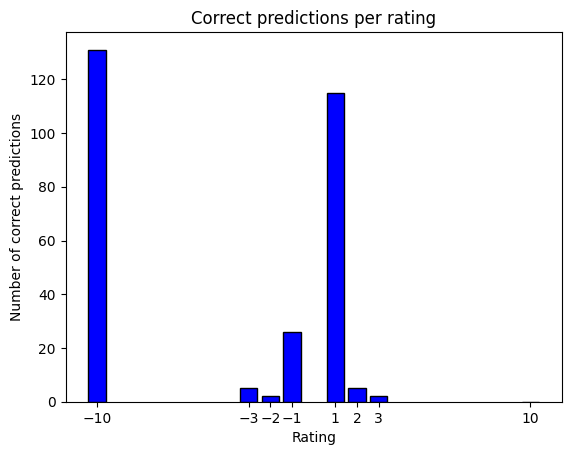

In [62]:
keys = list(correct_predictions.keys())
values = list(correct_predictions.values())

# Plot
plt.bar(keys, values, color='blue', edgecolor='black')
plt.xticks(keys)

# Labels and title
plt.xlabel('Rating')
plt.ylabel('Number of correct predictions')
plt.title('Correct predictions per rating')

In [49]:
wrong_predictions = dict()
ind = -1
for i in y_test2:
    ind = ind + 1
    if i != y_pred2[ind]:
        if wrong_predictions.get(i) == None:
            wrong_predictions[i] = 1
        else:
            wrong_predictions[i] = wrong_predictions.get(i) + 1
print(wrong_predictions)

{-5: 18, 1: 29, 2: 53, -1: 50, 3: 26, -10: 28, -8: 2, -3: 6, -2: 10, 5: 7, 10: 6, 8: 2, 4: 11, -4: 2, 7: 5, -9: 2, -7: 1, 6: 1, 9: 1}


Text(0.5, 1.0, 'Wrong predictions per rating')

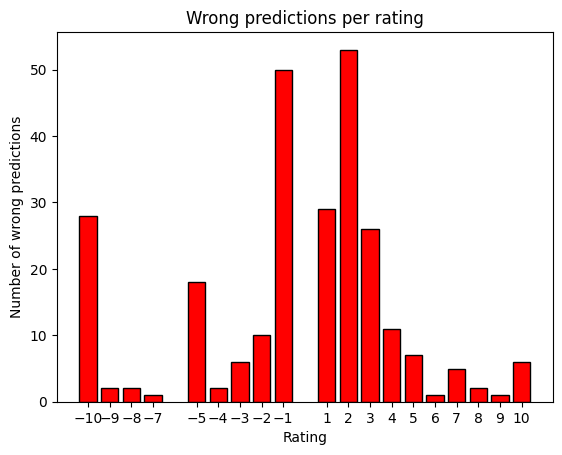

In [63]:
keys = list(wrong_predictions.keys())
values = list(wrong_predictions.values())

# Plot
plt.bar(keys, values, color='red', edgecolor='black')
plt.xticks(keys)


# Labels and title
plt.xlabel('Rating')
plt.ylabel('Number of wrong predictions')
plt.title('Wrong predictions per rating')

In [41]:
print(y_test2)

0      -1
1      -1
2     -10
3      -5
4       1
       ..
609     3
610     1
611     2
612     2
613   -10
Name: rating, Length: 546, dtype: int64
